# <div align="center">NYT: Multi-label Classification of Emotions
   <div align="center"> PRIMARY APPROACH
    



## 1. Import Libraries

In [11]:
!pip install plotly
!pip install prettytable
!pip install wordcloud
!pip install mlxtend

     |████████████████████████████████| 1.3 MB 4.0 MB/s eta 0:00:01


In [12]:
import warnings
warnings.filterwarnings("ignore")

import re
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict

#viz
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import missingno as msno
import seaborn as sns
sns.set_style("darkgrid")
import missingno as msno
from pylab import rcParams
rcParams['figure.figsize'] = 8, 6
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from prettytable import PrettyTable   
PTTable = PrettyTable()

#json zipped
import gzip
import json

#text
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stopword = nltk.corpus.stopwords.words('english')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

#for models and eval
from mlxtend.plotting import plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score

#Models
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression, SGDClassifier

#save model
import pickle

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/msarica/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/msarica/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/msarica/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /Users/msarica/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 2. Data Cleaning

In [46]:
#import data using read_csv method
df = pd.read_csv("nlp_encoded_nyt.csv", encoding="utf-8")

In [47]:
#getting top 2 rows
df.head(2)

,emotion_0,emotion_1,emotion_2,emotion_3,emotion_4,emotion_5,emotion_6,emotion_7,emotion_8,emotion_9,headline,summary,worker_id
0,0,0,0,0,0,1,0,0,0,1,Parenting Lessons From a Partial Eclipse,I don’t do partiality. Maybe it was finally ti...,95524929
1,0,0,0,0,0,1,0,0,0,1,On Catalonia,Catalan lawmakers declared independence from S...,30266977


In [48]:
#shape of the dataset
print("The shape of the dataset is {}.".format(df.shape))

The shape of the dataset is (95760, 13).


### 2.1 Info

* To get the initial idea about the data representation such as data types, null values, total rows and columns/features etc

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95760 entries, 0 to 95759
Data columns (total 13 columns):
emotion_0    95570 non-null object
emotion_1    95576 non-null object
emotion_2    95606 non-null object
emotion_3    95603 non-null object
emotion_4    95569 non-null object
emotion_5    95557 non-null object
emotion_6    95561 non-null object
emotion_7    95575 non-null object
emotion_8    95567 non-null object
emotion_9    95588 non-null object
headline     95570 non-null object
summary      95587 non-null object
worker_id    95568 non-null object
dtypes: object(13)
memory usage: 9.5+ MB


* All the data types are object type.
* Many of the features have null values present in the columns although not much

### 2.2 Null Value Analysis

In [50]:
def null_count_analysis(df):
    """
    This function provides us a dataframe which has null value analysis of given dataframe.
    Input:
    ------
        DataFrame(df) : pandas dataframe
    Output:
    ------
        DataFrame : dataframe with missing value analysis
    """
    count = df.isnull().sum()  #getting missing value counts
    cent = 100 * ((df.isnull().sum()) / (df.shape[0]))  #getting missing value percentage
    null_df = pd.concat([count, cent], axis=1).rename(columns = {0:"NULL_COUNT", 1:"NULL_PERCENTAGE"})  #creating dataframe and renaming column
    
    return null_df

In [51]:
null_df = null_count_analysis(df)
null_df

,NULL_COUNT,NULL_PERCENTAGE
emotion_0,190,0.198413
emotion_1,184,0.192147
emotion_2,154,0.160819
emotion_3,157,0.163952
emotion_4,191,0.199457
emotion_5,203,0.211988
emotion_6,199,0.207811
emotion_7,185,0.193191
emotion_8,193,0.201546
emotion_9,172,0.179616


* Here the labels are the emotions. For the null values present in the emotions feature/column, imputation will be difficult as I don't have full details on why data may be missing- domain/data knowldge is key

* Also null values present in the text part will add no value as we can't impute text

* It is better to drop the null values from the dataset.

In [52]:
#not many null value counts: rows can be dropped
df_m1 = df.dropna()

print("Shape of m1 : {}".format(df_m1.shape))

Shape of m1 : (93406, 13)


### 2.3 data Inconsistancies

In [53]:
#getting all emotion columns
emotions=['emotion_0', 'emotion_1','emotion_2','emotion_3','emotion_4',
          'emotion_5','emotion_6','emotion_7','emotion_8','emotion_9']
emotions_clean=['emotion_0', 'emotion_1','emotion_2','emotion_3','emotion_4','emotion_5',
                'emotion_6','emotion_7','emotion_8']


#emotions not binary 
def cols_val_cnts(df):
    """
    This function provides us a dataframe with value counts of each emotion columns.
    input:
    -----
        dataframe
    output:
    -------
        value count dataframe
    """
    df=df.apply(pd.Series.value_counts)
    return pd.DataFrame(df)

In [54]:
cols_val_cnts(df_m1[emotions])

,emotion_0,emotion_1,emotion_2,emotion_3,emotion_4,emotion_5,emotion_6,emotion_7,emotion_8,emotion_9
-1,203,196,209,190,179,202,166,187,185,186.0
-2,171,190,181,194,197,196,178,182,185,167.0
0,83701,83889,85307,85686,83481,56871,89266,76471,71788,NaN
1,8920,8760,7338,6960,9175,35759,3438,16180,20890,92669.0
cat,219,190,179,171,192,196,165,192,179,175.0
fnord,192,181,192,205,182,182,193,194,179,209.0


In [55]:
#removal of emotion_9 column
df_m2 = df_m1.drop(columns=["emotion_9"])

* The dataset contain values such as "-1", "-2", "cat", and "fnord".
* All emotion_9 values belong to 1, and has rest NaN values. This column can be dropped as it adds no value to model training

In [56]:
#removing rows with "cat", "fnord", "-2", and "-1"
for col in list(df_m2.columns):
    df_m2 = df_m2[df_m2[col] != "cat"]
    df_m2 = df_m2[df_m2[col] != "fnord"]
    df_m2 = df_m2[df_m2[col] != "-2"]
    df_m2 = df_m2[df_m2[col] != "-1"]  

* As I don't have full details on data acquisition or domain details regarding these data inconsistancies, I'll drop them
* As the count of data inconsistancies are not many in the dataset, I'll drop respective rows where these values are present.

In [57]:
print("Shape of m2 : {}".format(df_m2.shape))

Shape of m2 : (84853, 12)


### 2.4 dtype conversion

In [58]:
#iterating over columns to convert object type into float type then to int
for col in emotions[0:-1]:
    df_m2[col] = df_m2[col].astype(float).astype(int)
    
cols_val_cnts(df_m2[emotions[0:-1]])

,emotion_0,emotion_1,emotion_2,emotion_3,emotion_4,emotion_5,emotion_6,emotion_7,emotion_8
0,76639,76857,78134,78476,76450,52150,81684,70041,65703
1,8214,7996,6719,6377,8403,32703,3169,14812,19150


### 2.5 sum of emotion columns

In [59]:
# getting summation of each emotion columns and populating it into a new column called "sum"
df_m2["sum"] = df_m2[emotions[0:-1]].sum(axis=1)
#sorting dataframe with sum column
df_m2 = df_m2.sort_values(by='sum', ascending = True)#low sum first

### 2.6 Drop Duplicates by entire row

In [60]:
#adding a new column to fetch the duplicate count of each row
df_m2["duplicate_count"] = [0 for i in range(0,df_m2.shape[0])]
#using groupby method to count the duplicate columns
duplicate_df = df_m2.groupby(list(df_m2.columns)[0:-1]).agg("count").reset_index()
#dropping the column duplicate_count from the parent dataframe
df_m2 = df_m2.drop(columns = ["duplicate_count"])

In [61]:
#getting duplicate value count for each column
duplicate_df["duplicate_count"].value_counts()

1    84791
2       31
Name: duplicate_count, dtype: int64

In [62]:
duplicate_df[duplicate_df["duplicate_count"] == 2].head(2)

,emotion_0,emotion_1,emotion_2,emotion_3,emotion_4,emotion_5,emotion_6,emotion_7,emotion_8,headline,summary,worker_id,sum,duplicate_count
65,0,0,0,0,0,0,0,0,1,10 New Books We Recommend This Week,Suggested reading from critics and editors at ...,82710287,1,2
3225,0,0,0,0,0,0,0,0,1,Catalonia’s Independence Bid Shows Signs of St...,Demonstrators held a general strike in the res...,18956295,1,2


* From the entire df, we can see that 31 rows are repeated twice- identical
* This is not looking at the texts only, but text+emotion or all columns rowise

In [63]:
#dopping all duplicate rows
df_m3 = df_m2.drop_duplicates(subset=None, keep="first", inplace=False)#keeping the first unique row

In [64]:
print("Shape of m3 : {}".format(df_m3.shape))

Shape of m3 : (84822, 13)


In [65]:
df_m3['sum'].value_counts()

1    67197
2    13329
3     3584
4      661
5       43
6        6
7        1
0        1
Name: sum, dtype: int64

*  here we can see that there are many rows with emotions > one label

### 2.7 Handling duplicate texts

In [66]:
#column mapping
data_dict = {"emotion_0":"sum", "emotion_1":"sum", "emotion_2":"sum","emotion_3":"sum",
             "emotion_4":"sum", "emotion_5":"sum","emotion_6":"sum", "emotion_7":"sum",
             "emotion_8":"sum"}
#getting total repetition column wise
df_m4 = df_m3.groupby(['headline','summary'], as_index = False).agg(data_dict)

In [67]:
df_m4.head(2)

,headline,summary,emotion_0,emotion_1,emotion_2,emotion_3,emotion_4,emotion_5,emotion_6,emotion_7,emotion_8
0,#MeToo Floods Social Media With Stories of Har...,"Many women, as well as men, are using the hash...",0,0,0,1,4,2,0,7,2
1,"$1.3 Million Homes in Oregon, Michigan and Cal...",A Dwell-style home in Portland; a 1929 Tudor h...,1,0,0,0,1,3,0,0,5


I am adding each duplicate row's emotion labels and adding them one by one- For example, if emotion_5=3, then the duplicated texts = emotion_5=1 *3 

In [68]:
print("Shape of m4 : {}".format(df_m4.shape))

Shape of m4 : (9343, 11)


In [69]:
#iterating over columns for value counts
for i in df_m4.columns:
    print ("---- %s ---" % i)
    print (df_m4[i].value_counts())

---- headline ---
Homes for Sale in New York City                                             21
What to Cook This Weekend                                                   19
Homes for Sale in New York and New Jersey                                   10
Homes for Sale in New York and Connecticut                                   9
What to Cook This Week                                                       8
                                                                            ..
The Best and Worst of the Golden Globes                                      1
Where Tourism Thrives in Mexico, Bloodshed and Poverty Are Blocks Away       1
Terrorizing if Not Clearly Terrorist: What to Call the Las Vegas Attack?     1
Brett Ratner, Prominent Producer, Accused of Sexual Misconduct               1
New Zealand’s Election Had Been Predictable. Then ‘Jacindamania’ Hit.        1
Name: headline, Length: 9261, dtype: int64
---- summary ---
Here’s what you need to know to start your day.      

With the redundancies seen, we can now map them to binary 0,1 emotions

### 2.8 mapping the output emotions to binary values

In [70]:
emotions

['emotion_0',
 'emotion_1',
 'emotion_2',
 'emotion_3',
 'emotion_4',
 'emotion_5',
 'emotion_6',
 'emotion_7',
 'emotion_8',
 'emotion_9']

In [71]:
#mapping highest values to 1 and making it binary
val_dict = {0:0, 1:1, 2:1, 3:1, 4:1, 5:1, 6:1, 7:1, 8:1, 9:1, 10:1, 11:1, 12:1, 13:1, 14:1, 15:1, 16:1, 17:1, 18:1, 19:1, 20:1,
           23:1, 39:1, 68:1}
#iterating over columns to map higher values to binary
for col in emotions[0:-1]:
#     df_m4 = df_m4.replace({col : val_dict})
    df_m4[col] = df_m4[col].map(val_dict)

In [72]:
df_m4.head(2)

,headline,summary,emotion_0,emotion_1,emotion_2,emotion_3,emotion_4,emotion_5,emotion_6,emotion_7,emotion_8
0,#MeToo Floods Social Media With Stories of Har...,"Many women, as well as men, are using the hash...",0,0,0,1,1,1,0,1,1
1,"$1.3 Million Homes in Oregon, Michigan and Cal...",A Dwell-style home in Portland; a 1929 Tudor h...,1,0,0,0,1,1,0,0,1


### 2.9  sum of emotion columns

In [73]:
# getting summation of each emotion columns and making it to a new column called sum
df_m4["sum"] = df_m4[emotions[0:-1]].sum(axis=1)

In [74]:
df_m4["sum"].value_counts().sort_index()

1      10
2     229
3    1310
4    2579
5    2786
6    1751
7     521
8     137
9      20
Name: sum, dtype: int64

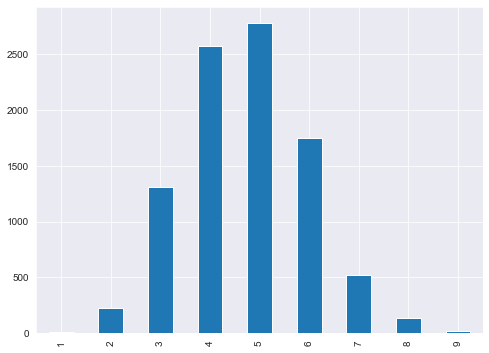

In [89]:
#plot the repetation
df_m4["sum"].value_counts().sort_index().plot(kind="bar")
plt.show()

### 2.10 getting final dataset after data cleaning

In [90]:
df_m5 = df_m4
#creating only text feature by adding headline and summary row-wise
df_m5["text"] = df_m4["headline"] + ". " + df_m4["summary"]
#view
df_m5.head(2)

,headline,summary,emotion_0,emotion_1,emotion_2,emotion_3,emotion_4,emotion_5,emotion_6,emotion_7,emotion_8,sum,text
0,#MeToo Floods Social Media With Stories of Har...,"Many women, as well as men, are using the hash...",0,0,0,1,1,1,0,1,1,5,#MeToo Floods Social Media With Stories of Har...
1,"$1.3 Million Homes in Oregon, Michigan and Cal...",A Dwell-style home in Portland; a 1929 Tudor h...,1,0,0,0,1,1,0,0,1,4,"$1.3 Million Homes in Oregon, Michigan and Cal..."


In [91]:
df_m5['sum'].value_counts(ascending=True)

1      10
9      20
8     137
2     229
7     521
3    1310
6    1751
4    2579
5    2786
Name: sum, dtype: int64

There are 20 instances with all 9 emotions- difficult without domain understanding whether to drop or not

In [92]:
print("Shape of m5 : {}".format(df_m5.shape))

Shape of m5 : (9343, 13)


In [93]:
final_df=df_m5

In [94]:
#final check of duplicated text
duplicate_check = final_df[final_df.duplicated(['text'])]
duplicate_check

,headline,summary,emotion_0,emotion_1,emotion_2,emotion_3,emotion_4,emotion_5,emotion_6,emotion_7,emotion_8,sum,text


# 3.0  Exploration of text anamolies

In [95]:
# printing min, max and mean of text length 
text_len = final_df.text.apply(lambda x: len(x))

print('\nMinimum length of the text:', text_len.min())
print('\nMaximum length of the text:', text_len.max())
print('\nMean length of the text:', int(text_len.mean()))


Minimum length of the text: 35

Maximum length of the text: 342

Mean length of the text: 188


In [96]:
#print max text
text_length = final_df.text.astype(str).map(len)
print (final_df.loc[text_length.argmax(), 'text'])

High School Students Explain Why They Protest Anthems and Pledges. Colin Kaepernick’s decision to sit or take a knee during the national anthem exploded into a national conversation about race. Here, high school students tell us why they sit or kneel during the national anthem or the Pledge of Allegiance — or why they stand and participate.


In [97]:
#print min text
print (final_df.loc[text_length.argmin(), 'text'])

Harvey, Part II. A new state motto?


In [98]:
#create a column of text length and sort ascending order
final_df['lentext'] = final_df['text'].str.len()
final_df.sort_values(by='lentext', ascending=True)

,headline,summary,emotion_0,emotion_1,emotion_2,emotion_3,emotion_4,emotion_5,emotion_6,emotion_7,emotion_8,sum,text,lentext
2991,"Harvey, Part II",A new state motto?,1,0,0,0,1,1,0,1,1,5,"Harvey, Part II. A new state motto?",35
5380,On Net Neutrality,Ctrl + Alt + Del.,0,1,0,0,0,1,0,1,1,4,On Net Neutrality. Ctrl + Alt + Del.,36
6537,Shell Game,David Steinberg fools us.,0,1,0,0,0,1,0,0,1,3,Shell Game. David Steinberg fools us.,37
5401,On the Paradise Papers,Abandon ship.,1,1,1,0,1,1,0,1,1,7,On the Paradise Papers. Abandon ship.,37
1796,Compromise,Peter Collins likes his medium.,0,0,0,0,0,1,1,0,1,3,Compromise. Peter Collins likes his medium.,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4550,M.L.B. 2017: Going ... Going ... Gone!,"Baseball ran on a power cord in 2017, setting ...",1,0,1,0,0,1,1,0,1,5,M.L.B. 2017: Going ... Going ... Gone!. Baseba...,302
8104,Turkish Gold Trader Cuts Deal With Prosecutors...,"The trader, who was arrested in 2016, is coope...",1,0,0,0,1,1,0,1,1,5,Turkish Gold Trader Cuts Deal With Prosecutors...,302
114,5 Destinations for the Thanksgiving Traveler,"For many Americans, Thanksgiving travel genera...",0,1,1,0,0,1,0,0,1,4,5 Destinations for the Thanksgiving Traveler. ...,317
5737,Puerto Rico’s Health Care Is in Dire Condition...,As the island struggles to recover from the de...,0,1,0,1,1,1,1,1,0,6,Puerto Rico’s Health Care Is in Dire Condition...,321


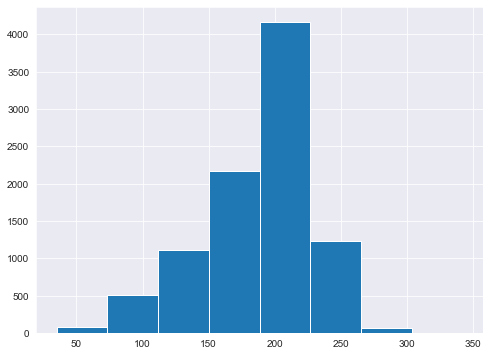

In [99]:
#Hist of lencount
final_df['lentext'].hist(bins=8)

Looks like the bulk of headline + summary are b/n 150 and 250 characters 

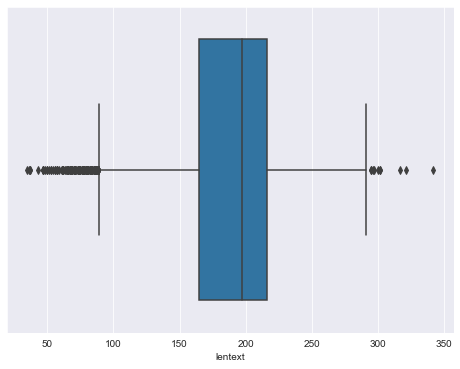

In [100]:
#text outliers
sns.boxplot(x=final_df["lentext"])

Text len outliers present on both tails, more so left tail

In [101]:
def find_outliers(df, var):
    lower_boundary = df[var].quantile(0.05)
    upper_boundary = df[var].quantile(0.95)
    return upper_boundary, lower_boundary
text_upper_limit, text_lower_limit = find_outliers(final_df, 'lentext')
text_upper_limit, text_lower_limit

(242.0, 106.0)

text length > 242 and <106 are considered outliers for NYT headline+summaries combined

In [102]:
#capture upper and lower len anomolies 
for column in final_df.columns:
    upper_text_len = final_df[final_df['lentext']>242.0]
    
for column in final_df.columns:
    lower_text_len = final_df[final_df['lentext']<106.0]
    
upper_text_len = ''.join(upper_text_len.text)
lower_text_len = ''.join(lower_text_len.text)

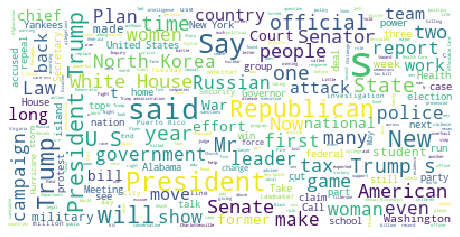

In [103]:
wordcloud = WordCloud().generate(upper_text_len)
# take relative word frequencies into account, lower max_font_size
wordcloud = WordCloud(background_color="white",max_words=len(upper_text_len),max_font_size=40, relative_scaling=.5).generate(upper_text_len)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

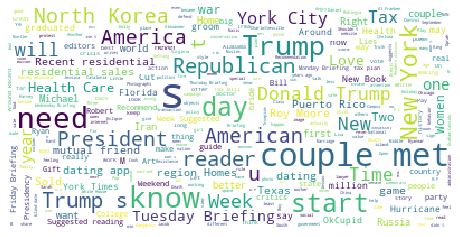

In [104]:
wordcloud = WordCloud().generate(lower_text_len)
# take relative word frequencies into account, lower max_font_size
wordcloud = WordCloud(background_color="white",max_words=len(lower_text_len),max_font_size=40, relative_scaling=.5).generate(lower_text_len)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

There is a slight distinction between upper and lower outliers. Where upper outliers are dominated by politics and int'l affairs, lower outliers tend to include diverse topics such as dating,couples,health, education, etc..

In [105]:
#text with all emotion and with only one emotion for word cloud
all_emotions=final_df.loc[final_df['sum'] == 9]
one_emotion=final_df.loc[final_df['sum'] == 1]

all_emotions = ''.join(all_emotions.text)
one_emotion = ''.join(one_emotion.text)

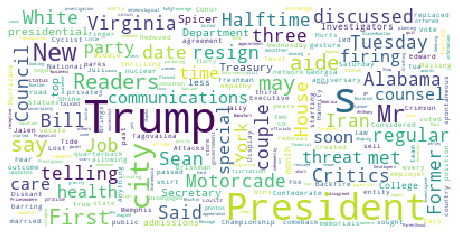

In [109]:
wordcloud = WordCloud().generate(all_emotions)
# take relative word frequencies into account, lower max_font_size
wordcloud = WordCloud(background_color="white",max_words=len(all_emotions),max_font_size=40, relative_scaling=.5).generate(all_emotions)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

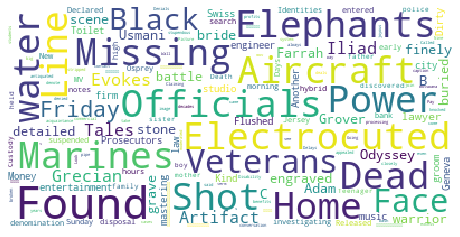

In [110]:
wordcloud = WordCloud().generate(one_emotion)
# take relative word frequencies into account, lower max_font_size
wordcloud = WordCloud(background_color="white",max_words=len(one_emotion),max_font_size=40, relative_scaling=.5).generate(one_emotion)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

*  texts with **all** emotions seem in someway to be associated with politics
*  texts with **one** emotion seem in someway to be associated with crime, violence, accident

## 3. Text Preprocessing

In [111]:
# This recieves a sentence 1 at a time
# Use a loop if you want to process a dataset or a lambda
def text_preprocess(text, stopwords, lemmatizer, wordnet_map):
    # Transform words to lower case
    text=text.lower()
    # Remove punctuation
    text=re.sub('[^a-zA-Z]', ' ', text)
    # Remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    # Remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    # Remove stop words like : and is a and the
    text=" ".join([word for word in text.split() if word not in stopwords])
    # Find base word for all words in the sentence
    pos_tagged_text=nltk.pos_tag(text.split())
    text=" ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])
    return text

# List of stop words [and, it, the, is, of, or, ...]
STOPWORDS=set(stopwords.words('english'))  
# Construct a lemmatizer for finding base words
lemmatizer=WordNetLemmatizer()
# Helper word map to find better base words than base lemmatizer 
wordnet_map={"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}

In [112]:
#Source:- https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490
def decontracted(text):
    for idx,val in tqdm(enumerate(text.values)):
        # specific
        val = re.sub(r"won\'t", "will not", val)
        val = re.sub(r"won\''t", "will not", val)
        val = re.sub(r"won\"t", "will not", val)
        val = re.sub(r"can\'t", "can not", val)
        val = re.sub(r"can\''t", "can not", val)
        val = re.sub(r"can\"t", "can not", val)
        # general
        val = re.sub(r"n\'t", " not", val)
        val = re.sub(r"n\''t", " not", val)
        val = re.sub(r"n\"t", " not", val)
        val = re.sub(r"\'re", " are", val)
        val = re.sub(r"\''re", " are", val)
        val = re.sub(r"\"re", " are", val)
        val = re.sub(r"\'s", " is", val)
        val = re.sub(r"\''s", " is", val)
        val = re.sub(r"\"s", " is", val)
        val = re.sub(r"\'d", " would", val)
        val = re.sub(r"\''d", " would", val)
        val = re.sub(r"\"d", " would", val)
        val = re.sub(r"\'ll", " will", val)
        val = re.sub(r"\''ll", " will", val)
        val = re.sub(r"\"ll", " will", val)
        val = re.sub(r"\'t", " not", val)
        val = re.sub(r"\''t", " not", val)
        val = re.sub(r"\"t", " not", val)
        val = re.sub(r"\'ve", " have", val)
        val = re.sub(r"\''ve", " have", val)
        val = re.sub(r"\"ve", " have", val)
        val = re.sub(r"\'m", " am", val)
        val = re.sub(r"\''m"," am", val)
        val = re.sub(r"\"m"," am", val)

        text.values[idx] = val.strip()
    return text

final_df['text'] = decontracted(final_df['text'])
final_df['text'] = decontracted(final_df['text'])

9343it [00:00, 33858.20it/s]
9343it [00:00, 36393.59it/s]


In [113]:
# Perform the text processing for all comments in the dataset using the text_preprocess method
final_df["preprocessed_text"] = df_m5['text'].apply(lambda x: text_preprocess(x, STOPWORDS, lemmatizer, wordnet_map))

In [114]:
#example
final_df["preprocessed_text"].values[100]

'hour kigali rwanda year horrific genocide rwanda kigali emerge proud city know great coffee din progressive start ups energetic art scene'

In [115]:
#replacing empty strings in our preprocessed column to np.nan and dropping Nan
final_df['preprocessed_text'].replace('', np.nan, inplace=True)
final_df.dropna(subset=['preprocessed_text'], inplace=True)

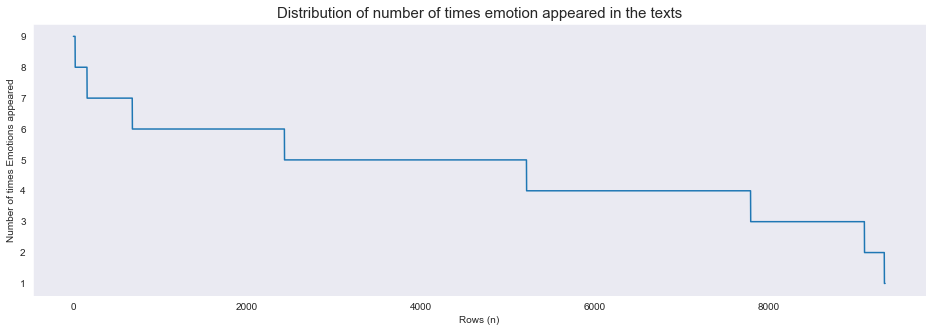

In [116]:
emotion_df_sorted = final_df.sort_values(['sum'], ascending=False)
label_count = emotion_df_sorted['sum'].values

#plot
plt.figure(figsize=(16,5))
plt.plot(label_count)
plt.title("Distribution of number of times emotion appeared in the texts", fontsize=15)
plt.xlabel("Rows (n)")
plt.ylabel("Number of times Emotions appeared")
plt.grid()
plt.show()

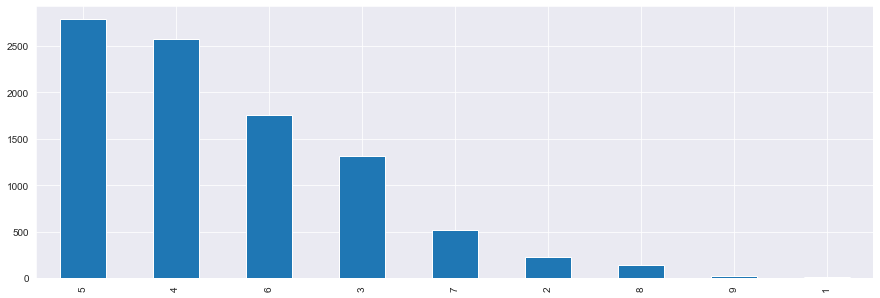

In [119]:
#plot the repetation
final_df["sum"].value_counts().plot(kind="bar", figsize=(15,5))
plt.show()

#### Observation:

* Emotion 5, 4 and 6 occure more frequently than other emotions


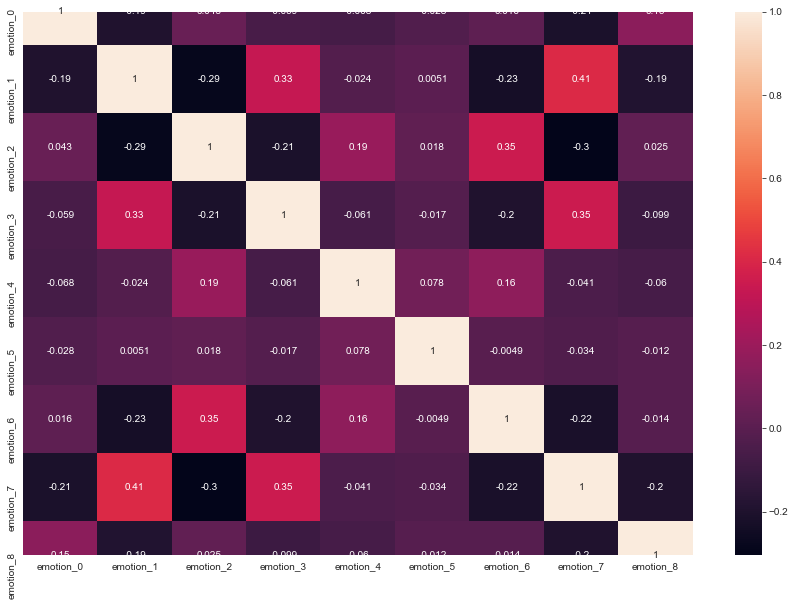

In [120]:
rcParams['figure.figsize'] = 15, 10
corrMatrix = final_df[emotions_clean].corr(method="pearson")
sns.heatmap(corrMatrix, annot=True)
plt.show()

No correlation b/n emotions

In [121]:
#least frequent words
least_freq = 20
#if not necessary all lower
k= final_df['preprocessed_text'].str.lower().str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(k)
word_dist = nltk.FreqDist(words)
print (word_dist)

result = pd.DataFrame(word_dist.most_common(least_freq),
                    columns=['Word', 'Frequency'])

print('there are no rare words')

result.sort_values(by='Frequency', ascending=True)

<FreqDist with 18117 samples and 180639 outcomes>
there are no rare words


,Word,Frequency
19,game,446
18,mr,460
17,republican,463
16,woman,463
15,take,478
14,north,503
13,first,531
12,time,548
11,city,558
10,state,581


# 4. Train-Test Split and Text Vectorization

In [122]:
train, test = train_test_split(final_df, random_state=42, test_size=0.20, shuffle=True)

In [123]:
train_emotions = train.preprocessed_text
test_emotions = test.preprocessed_text
print(train_emotions.shape)
print(test_emotions.shape)

(7473,)
(1869,)


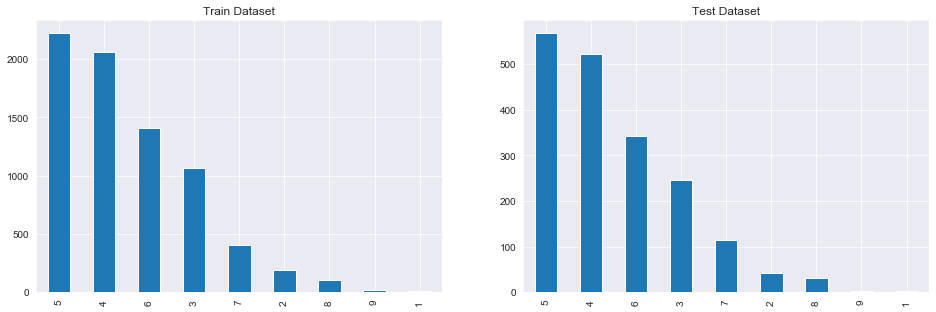

In [124]:
#plot train test dist
fig, ax = plt.subplots(ncols=2, figsize=(16,5))
train_sum = train["sum"].value_counts().plot(kind="bar",ax=ax[0], title="Train Dataset")
test_sum = test["sum"].value_counts().plot(kind="bar",ax=ax[1], title="Test Dataset")
plt.show()

In [125]:
#creating an object of TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,3), min_df=5, 
                             max_df=0.9,strip_accents='unicode',
                             use_idf=True, smooth_idf=True,
                             sublinear_tf=True)
vectorizer.fit(train_emotions)
vectorizer.fit(test_emotions)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.9, max_features=None,
                min_df=5, ngram_range=(1, 3), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents='unicode',
                sublinear_tf=True, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [126]:
X_train = vectorizer.transform(train_emotions)
ytrain = train.drop(labels = ['headline','summary','text','preprocessed_text','sum','lentext'], axis=1)

X_test = vectorizer.transform(test_emotions)
ytest = test.drop(labels = ['headline','summary','text','preprocessed_text','sum','lentext'], axis=1)

# 5. Model Building

### 5.1 Naive Bayes - Multinomial NB

In [127]:
MultinomialNB().get_params().keys()

dict_keys(['alpha', 'class_prior', 'fit_prior'])

In [128]:
param = [{'estimator__alpha': [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]}]  # creating parameter grid

# Optimal alpha by grid search 
NB_clf = OneVsRestClassifier(MultinomialNB(), n_jobs=-1)
Multinomial_NB = GridSearchCV(NB_clf, param, scoring = 'f1_micro', cv=5)

#fit and print best estimator  & CV Score
Multinomial_NB.fit(X_train, ytrain)
print(Multinomial_NB.best_estimator_)
print("Best Cross Validation Score: ",Multinomial_NB.best_score_)

#fit tuned clf on test set and gather accuracy and hamming loss
predictions = Multinomial_NB.predict(X_test)
print("\n Accuracy :",metrics.accuracy_score(ytest, predictions))
print("Hamming loss ",metrics.hamming_loss(ytest,predictions))

#micro- precision, recall, f1
precision=precision_score(ytest, predictions, average='micro')
recall=recall_score(ytest, predictions, average='micro')
f1=f1_score(ytest, predictions, average='micro')

#print precision, recall, f1 scores 
print("\n Micro-average")
print("Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(precision, recall, f1))


OneVsRestClassifier(estimator=MultinomialNB(alpha=1, class_prior=None,
                                            fit_prior=True),
                    n_jobs=-1)
Best Cross Validation Score:  0.7565236455120141

 Accuracy : 0.07865168539325842
Hamming loss  0.24879614767255218

 Micro-average
Precision: 0.7694, Recall: 0.7546, F1: 0.7619


In [129]:
#macro- precision, recall, f1 for micro avarage
precision=precision_score(ytest, predictions, average='macro')
recall=recall_score(ytest, predictions, average='macro')
f1=f1_score(ytest, predictions, average='macro')
 
#print precision, recall, f1 scores for micro avarage  
print("\n Macro-average")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

#print classification report of the multiple labels
print("\nClassification Report")
print (metrics.classification_report(ytest, predictions))


 Macro-average
Precision: 0.7171, Recall: 0.6686, F1-measure: 0.6790

Classification Report
              precision    recall  f1-score   support

           0       0.66      0.74      0.70       964
           1       0.70      0.63      0.66       775
           2       0.63      0.47      0.54       749
           3       0.69      0.62      0.65       644
           4       0.61      0.57      0.59       945
           5       0.96      1.00      0.98      1791
           6       0.61      0.21      0.31       448
           7       0.76      0.80      0.78      1020
           8       0.83      0.98      0.90      1538

   micro avg       0.77      0.75      0.76      8874
   macro avg       0.72      0.67      0.68      8874
weighted avg       0.76      0.75      0.75      8874
 samples avg       0.78      0.77      0.75      8874



### 5.2 Logistic Regression

In [130]:
#Parameters for classifier
LogisticRegression().get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [131]:
#alpha param space
param = [{'estimator__C': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]}]

# Optimal C by grid search 
log_reg_clf = OneVsRestClassifier(LogisticRegression(penalty='l2', class_weight='balanced'), n_jobs=-1)
logisticR = GridSearchCV(log_reg_clf, param,scoring = 'f1_micro', cv=5)


#fit and print best estimator  & CV Score
logisticR.fit(X_train, ytrain)
print(logisticR.best_estimator_)
print("Best Cross Validation Score: ",logisticR.best_score_)

#fit tuned clf on test set and gather accuracy and hamming loss
predictions = logisticR.predict(X_test)
print("\n Accuracy :",metrics.accuracy_score(ytest, predictions))
print("Hamming loss ",metrics.hamming_loss(ytest,predictions))

#micro- precision, recall, f1
precision=precision_score(ytest, predictions, average='micro')
recall=recall_score(ytest, predictions, average='micro')
f1=f1_score(ytest, predictions, average='micro')

#print precision, recall, f1 scores 
print("\n Micro-average")
print("Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(precision, recall, f1))

OneVsRestClassifier(estimator=LogisticRegression(C=0.1, class_weight='balanced',
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='warn', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=-1)
Best Cross Validation Score:  0.719802288272271

 Accuracy : 0.04922418405564473
Hamming loss  0.2847036442542061

 Micro-average
Precision: 0.7340, Recall: 0.7220, F1: 0.7279


In [132]:
#macro- precision, recall, f1 for micro avarage
precision=precision_score(ytest, predictions, average='macro')
recall=recall_score(ytest, predictions, average='macro')
f1=f1_score(ytest, predictions, average='macro')
 
#print precision, recall, f1 scores for micro avarage  
print("\n Macro-average")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

#print classification report of the multiple labels
print("\nClassification Report")
print (metrics.classification_report(ytest, predictions))


 Macro-average
Precision: 0.6927, Recall: 0.6967, F1-measure: 0.6914

Classification Report
              precision    recall  f1-score   support

           0       0.67      0.67      0.67       964
           1       0.67      0.71      0.69       775
           2       0.59      0.63      0.61       749
           3       0.64      0.69      0.67       644
           4       0.61      0.61      0.61       945
           5       0.97      0.88      0.92      1791
           6       0.43      0.62      0.51       448
           7       0.77      0.75      0.76      1020
           8       0.88      0.72      0.79      1538

   micro avg       0.73      0.72      0.73      8874
   macro avg       0.69      0.70      0.69      8874
weighted avg       0.75      0.72      0.73      8874
 samples avg       0.74      0.73      0.72      8874



### 5.3 SGDClassiffier with log loss 

In [133]:
SGDClassifier().get_params().keys()

dict_keys(['alpha', 'average', 'class_weight', 'early_stopping', 'epsilon', 'eta0', 'fit_intercept', 'l1_ratio', 'learning_rate', 'loss', 'max_iter', 'n_iter_no_change', 'n_jobs', 'penalty', 'power_t', 'random_state', 'shuffle', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [134]:
#setup params
param= {'estimator__alpha':[100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
              'estimator__epsilon':[100, 10, 1, 0.1, 0.01, 0.001, 0.0001]} #creating parameter grid

# Optimal alpha,epsilon by grid search #logloss 
SGDC_clf = OneVsRestClassifier(SGDClassifier(loss = 'log', random_state=42,class_weight='balanced'), n_jobs=-1)
SGDC_log = GridSearchCV(SGDC_clf, param,scoring = 'f1_micro', cv=5)

#fit and print best estimator  & CV Score
SGDC_log.fit(X_train, ytrain)
print(SGDC_log.best_estimator_)
print("Best Cross Validation Score: ",SGDC_log.best_score_)

#fit tuned clf on test set and gather accuracy and hamming loss
predictions = SGDC_log.predict(X_test)
print("\n Accuracy :",metrics.accuracy_score(ytest, predictions))
print("Hamming loss ",metrics.hamming_loss(ytest,predictions))

#micro- precision, recall, f1
precision=precision_score(ytest, predictions, average='micro')
recall=recall_score(ytest, predictions, average='micro')
f1=f1_score(ytest, predictions, average='micro')

#print precision, recall, f1 scores 
print("\n Micro-average")
print("Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(precision, recall, f1))


OneVsRestClassifier(estimator=SGDClassifier(alpha=0.001, average=False,
                                            class_weight='balanced',
                                            early_stopping=False, epsilon=100,
                                            eta0=0.0, fit_intercept=True,
                                            l1_ratio=0.15,
                                            learning_rate='optimal', loss='log',
                                            max_iter=1000, n_iter_no_change=5,
                                            n_jobs=None, penalty='l2',
                                            power_t=0.5, random_state=42,
                                            shuffle=True, tol=0.001,
                                            validation_fraction=0.1, verbose=0,
                                            warm_start=False),
                    n_jobs=-1)
Best Cross Validation Score:  0.7176011320247684

 Accuracy : 0.051364365971107544
Hamming loss  0.

In [135]:
#macro- precision, recall, f1 for micro avarage
precision=precision_score(ytest, predictions, average='macro')
recall=recall_score(ytest, predictions, average='macro')
f1=f1_score(ytest, predictions, average='macro')
 
#print precision, recall, f1 scores for micro avarage  
print("\n Macro-average")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

#print classification report of the multiple labels
print("\nClassification Report")
print (metrics.classification_report(ytest, predictions))


 Macro-average
Precision: 0.6943, Recall: 0.6956, F1-measure: 0.6913

Classification Report
              precision    recall  f1-score   support

           0       0.67      0.67      0.67       964
           1       0.67      0.71      0.69       775
           2       0.59      0.63      0.61       749
           3       0.65      0.70      0.67       644
           4       0.61      0.60      0.61       945
           5       0.97      0.86      0.91      1791
           6       0.44      0.63      0.51       448
           7       0.77      0.75      0.76      1020
           8       0.88      0.71      0.79      1538

   micro avg       0.73      0.72      0.73      8874
   macro avg       0.69      0.70      0.69      8874
weighted avg       0.75      0.72      0.73      8874
 samples avg       0.74      0.73      0.71      8874



### 5.4 SGDClassifier with Hinge loss

In [136]:
#setup params
param= {'estimator__alpha':[100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
              'estimator__epsilon':[100, 10, 1, 0.1, 0.01, 0.001, 0.0001]} #creating parameter grid


# Optimal alpha,epsilon by grid search #hinge
SGDC_clf = OneVsRestClassifier(SGDClassifier(loss = 'hinge', random_state=42,class_weight='balanced'), n_jobs=-1)
SGDC_log = GridSearchCV(SGDC_clf, param,scoring = 'f1_micro', cv=5)

#fit and print best estimator  & CV Score
SGDC_log.fit(X_train, ytrain)
print(SGDC_log.best_estimator_)
print("Best Cross Validation Score: ",SGDC_log.best_score_)

#fit tuned clf on test set and gather accuracy and hamming loss
predictions = SGDC_log.predict(X_test)
print("\n Accuracy :",metrics.accuracy_score(ytest, predictions))
print("Hamming loss ",metrics.hamming_loss(ytest,predictions))

#micro- precision, recall, f1
precision=precision_score(ytest, predictions, average='micro')
recall=recall_score(ytest, predictions, average='micro')
f1=f1_score(ytest, predictions, average='micro')

#print precision, recall, f1 scores 
print("\n Micro-average")
print("Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(precision, recall, f1))


OneVsRestClassifier(estimator=SGDClassifier(alpha=0.001, average=False,
                                            class_weight='balanced',
                                            early_stopping=False, epsilon=100,
                                            eta0=0.0, fit_intercept=True,
                                            l1_ratio=0.15,
                                            learning_rate='optimal',
                                            loss='hinge', max_iter=1000,
                                            n_iter_no_change=5, n_jobs=None,
                                            penalty='l2', power_t=0.5,
                                            random_state=42, shuffle=True,
                                            tol=0.001, validation_fraction=0.1,
                                            verbose=0, warm_start=False),
                    n_jobs=-1)
Best Cross Validation Score:  0.7131620534672881

 Accuracy : 0.04173354735152488
Hamming loss  0

In [137]:
#macro- precision, recall, f1 for micro avarage
precision=precision_score(ytest, predictions, average='macro')
recall=recall_score(ytest, predictions, average='macro')
f1=f1_score(ytest, predictions, average='macro')
 
#print precision, recall, f1 scores for micro avarage  
print("\n Macro-average")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

#print classification report of the multiple labels
print("\nClassification Report")
print (metrics.classification_report(ytest, predictions))


 Macro-average
Precision: 0.6943, Recall: 0.6883, F1-measure: 0.6876

Classification Report
              precision    recall  f1-score   support

           0       0.66      0.69      0.68       964
           1       0.68      0.69      0.68       775
           2       0.60      0.62      0.61       749
           3       0.65      0.66      0.66       644
           4       0.60      0.63      0.61       945
           5       0.97      0.83      0.90      1791
           6       0.43      0.62      0.51       448
           7       0.78      0.73      0.75      1020
           8       0.88      0.72      0.80      1538

   micro avg       0.73      0.71      0.72      8874
   macro avg       0.69      0.69      0.69      8874
weighted avg       0.75      0.71      0.73      8874
 samples avg       0.74      0.72      0.71      8874



### 5.5 Support Vector Machine

In [138]:
LinearSVC().get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'loss', 'max_iter', 'multi_class', 'penalty', 'random_state', 'tol', 'verbose'])

In [139]:
#alpha param space
param = [{'estimator__C': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]}]

# Optimal C by grid search 
svc_clf = OneVsRestClassifier(LinearSVC(class_weight='balanced'), n_jobs=-1)
linear_SVC = GridSearchCV(svc_clf, param, scoring = 'f1_micro', cv=5)

#fit and print best estimator  & CV Score
linear_SVC.fit(X_train, ytrain)
print(linear_SVC.best_estimator_)
print("Best Cross Validation Score: ",linear_SVC.best_score_)

#fit tuned clf on test set and gather accuracy and hamming loss
predictions = linear_SVC.predict(X_test)
print("\n Accuracy :",metrics.accuracy_score(ytest, predictions))
print("Hamming loss ",metrics.hamming_loss(ytest,predictions))

#micro- precision, recall, f1
precision=precision_score(ytest, predictions, average='micro')
recall=recall_score(ytest, predictions, average='micro')
f1=f1_score(ytest, predictions, average='micro')

#print precision, recall, f1 scores 
print("\n Micro-average")
print("Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(precision, recall, f1))


OneVsRestClassifier(estimator=LinearSVC(C=0.01, class_weight='balanced',
                                        dual=True, fit_intercept=True,
                                        intercept_scaling=1,
                                        loss='squared_hinge', max_iter=1000,
                                        multi_class='ovr', penalty='l2',
                                        random_state=None, tol=0.0001,
                                        verbose=0),
                    n_jobs=-1)
Best Cross Validation Score:  0.7200088849989909

 Accuracy : 0.047619047619047616
Hamming loss  0.28315795731526067

 Micro-average
Precision: 0.7354, Recall: 0.7237, F1: 0.7295


In [140]:
#macro- precision, recall, f1 for micro avarage
precision=precision_score(ytest, predictions, average='macro')
recall=recall_score(ytest, predictions, average='macro')
f1=f1_score(ytest, predictions, average='macro')
 
#print precision, recall, f1 scores for micro avarage  
print("\n Macro-average")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

#print classification report of the multiple labels
print("\nClassification Report")
print (metrics.classification_report(ytest, predictions))


 Macro-average
Precision: 0.6936, Recall: 0.6975, F1-measure: 0.6924

Classification Report
              precision    recall  f1-score   support

           0       0.67      0.67      0.67       964
           1       0.67      0.70      0.68       775
           2       0.59      0.63      0.61       749
           3       0.64      0.68      0.66       644
           4       0.61      0.61      0.61       945
           5       0.97      0.89      0.93      1791
           6       0.43      0.62      0.51       448
           7       0.77      0.75      0.76      1020
           8       0.88      0.72      0.79      1538

   micro avg       0.74      0.72      0.73      8874
   macro avg       0.69      0.70      0.69      8874
weighted avg       0.75      0.72      0.74      8874
 samples avg       0.74      0.74      0.72      8874



### 5.6 Decision Tree Classifier

In [141]:
DecisionTreeClassifier().get_params().keys()

dict_keys(['class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'presort', 'random_state', 'splitter'])

In [142]:
param= {'estimator__max_depth':[50,100,200,300,500,1000],
              'estimator__min_samples_split':[100,200,300,500]} #parameter grid


#Optimal depth and split by grid search 
DT_clf = OneVsRestClassifier(DecisionTreeClassifier(class_weight='balanced'), n_jobs=-1)
DTree = GridSearchCV(DT_clf, param, scoring = 'f1_micro', cv=5)

#fit and print best estimator  & CV Score
DTree.fit(X_train, ytrain)
print(DTree.best_estimator_)
print("Best Cross Validation Score: ",DTree.best_score_)

#fit tuned clf on test set and gather accuracy and hamming loss
predictions = DTree.predict(X_test)
print("\n Accuracy :",metrics.accuracy_score(ytest, predictions))
print("Hamming loss ",metrics.hamming_loss(ytest,predictions))

#micro- precision, recall, f1
precision=precision_score(ytest, predictions, average='micro')
recall=recall_score(ytest, predictions, average='micro')
f1=f1_score(ytest, predictions, average='micro')

#print precision, recall, f1 scores 
print("\n Micro-average")
print("Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(precision, recall, f1))


OneVsRestClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                     criterion='gini',
                                                     max_depth=50,
                                                     max_features=None,
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=500,
                                                     min_weight_fraction_leaf=0.0,
                                                     presort=False,
                                                     random_state=None,
                                                     splitter='best'),
                    n_jobs=-1)
Best C

In [143]:
#macro- precision, recall, f1 for micro avarage
precision=precision_score(ytest, predictions, average='macro')
recall=recall_score(ytest, predictions, average='macro')
f1=f1_score(ytest, predictions, average='macro')
 
#print precision, recall, f1 scores for micro avarage  
print("\n Macro-average")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

#print classification report of the multiple labels
print("\nClassification Report")
print (metrics.classification_report(ytest, predictions))


 Macro-average
Precision: 0.6441, Recall: 0.6414, F1-measure: 0.6213

Classification Report
              precision    recall  f1-score   support

           0       0.58      0.82      0.68       964
           1       0.62      0.62      0.62       775
           2       0.58      0.41      0.48       749
           3       0.55      0.69      0.61       644
           4       0.60      0.38      0.47       945
           5       0.97      0.75      0.85      1791
           6       0.31      0.78      0.45       448
           7       0.73      0.63      0.68      1020
           8       0.86      0.70      0.77      1538

   micro avg       0.67      0.65      0.66      8874
   macro avg       0.64      0.64      0.62      8874
weighted avg       0.71      0.65      0.67      8874
 samples avg       0.67      0.66      0.65      8874



# 6. Model performance summary

In [144]:
#summary of the different models
PTTable.field_names = ["Sl No", "Model", "CV Score", "Hamming Loss","Precision","Recall","F1[Micro Avg.]"]
PTTable.add_row([1, "MultinomialNB", 0.76,0.25,0.77,0.75,0.76])
PTTable.add_row([2, "Logistic Regression", 0.72, 0.29,0.72,0.73,0.73])
PTTable.add_row(["\n","\n","\n","\n","\n","\n",""])
PTTable.add_row([3, "SGDClassifierLogLoss", 0.72, 0.29,0.73,0.72,0.73])
PTTable.add_row([4, "SGDClassifierHingeLoss", 0.71,0.29,0.73,0.71,0.72])
PTTable.add_row(["\n","\n","\n","\n","\n","\n",""])
PTTable.add_row([5, "LinearSVM", 0.72,0.28,0.74,0.72,0.73])
PTTable.add_row([6, "Decision Tree",0.65,0.36,0.67,0.65,0.66])


print(PTTable)

+-------+------------------------+----------+--------------+-----------+--------+----------------+
| Sl No |         Model          | CV Score | Hamming Loss | Precision | Recall | F1[Micro Avg.] |
+-------+------------------------+----------+--------------+-----------+--------+----------------+
|   1   |     MultinomialNB      |   0.76   |     0.25     |    0.77   |  0.75  |      0.76      |
|   2   |  Logistic Regression   |   0.72   |     0.29     |    0.72   |  0.73  |      0.73      |
|       |                        |          |              |           |        |                |
|       |                        |          |              |           |        |                |
|   3   |  SGDClassifierLogLoss  |   0.72   |     0.29     |    0.73   |  0.72  |      0.73      |
|   4   | SGDClassifierHingeLoss |   0.71   |     0.29     |    0.73   |  0.71  |      0.72      |
|       |                        |          |              |           |        |                |
|       | 

# 7. Save model and predict

In [145]:
# save best model
# filename = 'Multinomial_NB.pickle'
# pickle.dump(Multinomial_NB, open(filename, 'wb'))

In [153]:
# List of stop words [and, it, the, is, of, or, ...]
STOPWORDS=set(stopwords.words('english'))  
# Construct a lemmatizer for finding base words
lemmatizer=WordNetLemmatizer()
# Helper word map to find better base words than base lemmatizer 
wordnet_map={"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}

In [154]:
filename = 'model.pickle'
what_to_pickle = {
    'model': Multinomial_NB,
    'stopwords': STOPWORDS,
    'lemmatizer': lemmatizer,
    'wordnet_map': wordnet_map,
    'vectorizer': vectorizer
}

pickle.dump(what_to_pickle, open(filename, 'wb'))

In [155]:
#prediction pipeline with text vectorizer and model
def prediction(text_input, STOPWORDS, lemmatizer, wordnet_map, vectorizer, Multinomial_NB):
    
    # Transform words to lower case
    text=text_input.lower()
    # Remove punctuation
    text=re.sub('[^a-zA-Z]', ' ', text)
    # Remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    # Remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    # Remove stop words like : and is a and the
    text=" ".join([word for word in text.split() if word not in STOPWORDS])
    # Find base word for all words in the sentence
    pos_tagged_text=nltk.pos_tag(text.split())
    text=" ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])
    
    # specific
    text = re.sub(r"won\'t", "will not", text); text = re.sub(r"can\'t", "can not", text)
    # general
    text = re.sub(r"n\'t", " not", text); text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text); text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text); text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text); text = re.sub(r"\'m", " am", text)
    print(text)
    text = np.array(text).reshape(1,)
    vec_text = vectorizer.transform(text)
    output = Multinomial_NB.predict(vec_text)
    
    #creating dataframe
    cols = ['text','emotion_0','emotion_1','emotion_2','emotion_3','emotion_4',
            'emotion_5','emotion_6','emotion_7','emotion_8']
    vals = [[text_input] + list(output[0])]
    df = pd.DataFrame(vals, columns=cols)
    
    return df


In [156]:
#Source[BBC]: https://www.bbc.com/news/world-asia-56546920
text_input= "Myanmar coup: Dozens killed as army opens fire on protesters during deadliest day.Security forces were out in strength trying to prevent rallies.Local news site Myanmar Now put the death toll at 114, while the United Nations said it was receiving reports of scores killed and hundreds more injured."
print(text_input)

Myanmar coup: Dozens killed as army opens fire on protesters during deadliest day.Security forces were out in strength trying to prevent rallies.Local news site Myanmar Now put the death toll at 114, while the United Nations said it was receiving reports of scores killed and hundreds more injured.


In [157]:
#Prediction output
output= prediction(text_input, STOPWORDS, lemmatizer, wordnet_map, vectorizer, Multinomial_NB)
output

myanmar coup dozen kill army open fire protester deadliest day security force strength try prevent rally local news site myanmar put death toll united nation say receive report score kill hundred injure


,text,emotion_0,emotion_1,emotion_2,emotion_3,emotion_4,emotion_5,emotion_6,emotion_7,emotion_8
0,Myanmar coup: Dozens killed as army opens fire...,0,1,0,0,0,1,0,1,0


The new input text can be classfied within emotions: 1,5 and 7